### Stream-hyporheic simulations at watershed scale
$ \color{green }{\text{Model domain:}}$ Watershed : Area = 8 km x 6 km, mesh resolution = 100 m

$\color{green }{\text{Stream characteristics:}}$: Discharge [$m^3$/second], cross-sectional area [m^2], and lengths [m] are extracted from NHDPlus database

$\color{green }{\text{Stream characteristics:}}$: Implied sources of water to first-order stream are extracted from NHDPlus database

$ \color{green }{\text{Subgrid model:}}$ LogNormal travel time distribution with mean lifetime of 5 hours

$\color{green}{\text{Mesh:}}$ logical mesh (read from file)

$\color{green}{\text{Bondary conditions:}}$ prescribed concentration and implied source (incoming water) to the first-order streams provided sources to the first-order streams (source = Q* C)

$\color{green}{\text{Initial conditions:}}$ provided by pflotran (see data/pflotran_in/denitrification_reach.in), same initial condition for the stream and subgrid

$\text{Diffusion = 0.0 m$^2$/sec, Dispersion = 0}$

$\color{green}{\text{Simulation time :}}$ 16 hours

$\color{green}{\text{Chemsitry:}}$ denitrification

$\color{green}{\text{Numerical experiment:}}$ Forest condition are applied for 12 hours to get steady-state, then a pulse of farm condition is introduced for 4 hours.

$\color{green}{\text{Plotting:}}$  DOM, Nitrate and Oxygen removel in percentage against vs travel distance.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py

from matplotlib import animation
from matplotlib import cm
from mpl_toolkits import mplot3d
import os,sys

sys.path.append('/Users/ajc/Core/codes/simulator/debug/ats/tools/utils')
import read_helper as read
import seaborn as sns
import geopy.distance


In [27]:
sim = 'test1'
path = '/Users/ajc/FUSE/simulations/tests/ats-demos/13_reactive_transport/04_watershed_subgrid/%s/'%sim
#path = '/Users/ajc/Core/simulations/tests/ats-demos/13_reactive_transport/04_hyporheic_watershed/%s/'%sim
infile = [os.path.join(path,'visdump_surface_data.h5'), os.path.join(path,'visdump_surface_mesh.h5') ]
outfile='/Users/ajc/Core/PostProcessing/ReactiveTransport/Hyporheic/Coweeta/June11/%s/'%sim
#os.mkdir(outfile)

In [28]:
mesh = h5py.File(infile[1],'r')
mesh_data = list(mesh['0']['Mesh']['Nodes'])
var = 'surface-total_component_concentration'
Suffix = ['DOM1', 'NO3-', 'N2(aq)','O2(aq)']
microM = 1e+6
#Suffix = ['Tracer1']

In [29]:
Stream_C = dict()
for i, v in enumerate(Suffix):
    print (Suffix[i],var)
    Stream_C[Suffix[i]] = read.GetSurfVarFromVis_All(infile[0],var,suffix='.cell.'+Suffix[i])[var]
cycles = len(Stream_C[Suffix[0]])
print (len(Stream_C[Suffix[0]]),Stream_C.keys())

DOM1 surface-total_component_concentration
NO3- surface-total_component_concentration
N2(aq) surface-total_component_concentration
O2(aq) surface-total_component_concentration
361 dict_keys(['DOM1', 'NO3-', 'N2(aq)', 'O2(aq)'])


In [5]:
X_mesh = []
Y_mesh = []
Z_mesh = []

for m in mesh_data:#[:30]:
    X_mesh.append(m[0])
    Y_mesh.append(m[1])
    Z_mesh.append(m[2])
    

def subgrid_C(sg_file,sg_var, suff):
    sgC_data = read.GetSurfVarFromVis_All(sg_file,sg_var,suffix='.cell.'+suff)
    sgConcentration = sgC_data[sg_var]
    return sgConcentration

-83.48060367992423 -83.39664444859618
35.02446722540252 35.08045573244733


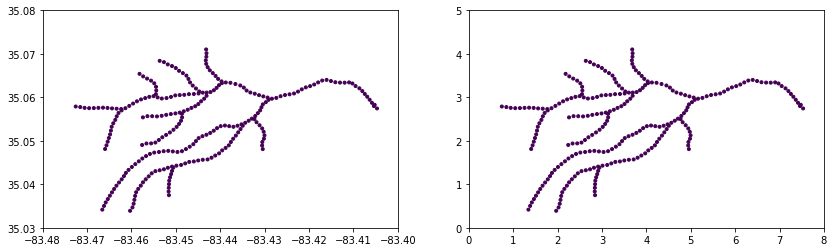

In [6]:
X_mesh = []
Y_mesh = []
Z_mesh = []

for m in mesh_data:
    X_mesh.append(m[0])
    Y_mesh.append(m[1])
    Z_mesh.append(m[2])

def get_limits():
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(121)

    ax.scatter(X_mesh,Y_mesh,marker=".",c=Z_mesh)
    #ax.set_xlim(xmin-0.0005,xmax)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    print(xmin,xmax)
    print(ymin,ymax)
    X0 = [-83.48, -83.40]
    Y0 = [35.03, 35.08]
    ax.set_xlim(X0)
    ax.set_ylim(Y0)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    xx = geopy.distance.geodesic(xmin,xmax).km + 0.07
    yy = geopy.distance.geodesic(ymin,ymax).km + 0.455
    Xlabels = np.round(np.linspace(0,xx,10,dtype=int),2)
    Ylabels = np.round(np.linspace(0,yy,7,dtype=int),2)

    ax = fig.add_subplot(122)
    ax.scatter(X_mesh,Y_mesh,marker=".",c=Z_mesh)
    ax.set_xticklabels(Xlabels)
    ax.set_yticklabels(Ylabels)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    plt.show()
    return X0, Y0, Xlabels, Ylabels

X0, Y0, Xlabels,Ylabels = get_limits()



In [7]:
# we only pick a few subgrid columns, could be one column per reach or user picked locations
cell1 = np.array([30, 7, 11, 3,10,20, 30, 9,17,12, 11, 5,2,8, 13, 10,8,8, 11, 12,9,14]) #cells per stream
cell2 = np.cumsum(cell1)

vis_columns = [0,15, 25] + [int((cell2[i] + cell2[i+1])/2.) for i in range(1,9) ] + [int((cell2[i] + cell2[i+1])/2.) for i in range(13,20) ]

vis_columns = [0,90, 120,140,200] #+ [int((cell2[i] + cell2[i+1])/2.) for i in range(1,21) ]


#### watershed and subgrid can be plotted in multiple ways:
#### plot_2D_surface_2D_subgrid() maps the subgrid concentration from a cell (hyporheic age) to the 2D surface

In [19]:
#%matplotlib qt

def plot_2D_surface_2D_subgrid():
    x_orig = X_mesh
    y_orig = Y_mesh
    
    count = 0
    time = [np.round(t*360/3600,2) for t in range(cycles)]
    for k in range(0,cycles,1):
        fig = plt.figure(figsize=(14,5))

        ax = fig.add_subplot(121)
        plt.tight_layout()

        var = Suffix[1]

        ran = Stream_C[var][k]
        ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran] #<-- converting to micro-moles
        
        # l_max # <-- problem/scenario dependent value 
        if np.max(ran) <3:
            l_max = 2 
        else:
            l_max = 200 
        sc = ax.scatter(X_mesh,Y_mesh,marker=".",c=ran,cmap=plt.get_cmap('jet'),vmin=1.,vmax=l_max)#,norm=matplotlib.colors.LogNorm())
        ax.text(X_mesh[-1]-0.02,Y_mesh[-1]+0.025, 'Time = %s [hr]'%time[k],fontsize=12,fontstyle='normal')
        cb = plt.colorbar(sc,pad=0.02,fraction=0.046)
        cb.ax.set_ylabel(r'Concentration [$\mu$M]',labelpad=-70, y=1.1,rotation=0,fontsize=12)

        ax.set_xlim(X0)
        ax.set_ylim(Y0)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xticklabels(Xlabels)
        ax.set_yticklabels(Ylabels)
        ax.set_xlabel('Distance [km]',fontsize=12, fontweight='normal')
        ax.set_ylabel('Distance [km]')
        plt.tight_layout(h_pad=1)

        sub_c = []
        sub_x = []
        sub_y = []
        sub_top = []
    
        ax = fig.add_subplot(122)
        
        for x1 in range(0,len(x_orig),30):
            #print (x1)
            sg_infile = os.path.join(path,'visdump_subgrid_%s_data.h5'%x1)

            ran = subgrid_C(sg_infile,sg_var='subgrid_%s-total_component_concentration'%x1,suff=Suffix[0])[k][::-1]
            ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran]
            Z_sgmesh = np.arange(0.05,1.05,0.05)#,dtype='int')
            Z_sgmesh = np.linspace(0,1.,20)
            s2 = ran[-2] + 0.001*x1#return for 2nd cell
            sub_c.append(s2)
            sub_x.append(x_orig[x1])
            sub_y.append(y_orig[x1])

            width = depth = 0.001
            bottom, top = 0, s2
        sc1 = ax.scatter(X_mesh,Y_mesh,marker=".",cmap=plt.get_cmap('gray'),alpha=0.3,s=2)
        sc1 = ax.scatter(sub_x,sub_y,marker="*",c=sub_c,cmap=plt.get_cmap('jet'),vmin=1,vmax=l_max)#,norm=matplotlib.colors.LogNorm())

        cb = plt.colorbar(sc1)
        cb.ax.set_ylabel(r'Concentration [$ \mu M$]',labelpad=-70, y=1.1,rotation=0)
        ax.set_xlim(X0)
        ax.set_ylim(Y0)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xticklabels(Xlabels)
        ax.set_yticklabels(Ylabels)
        ax.set_xlabel('Distance [km]')
        #ax.set_ylabel('Distance [km]')
        plt.tight_layout()
        #plt.savefig(outfile + '/%s/fig-%s.png'%(var,k),dpi=100)

        
        #plt.close()
        count +=1

        if count >1:
            print ('Count: ',count)
            break

Count:  2


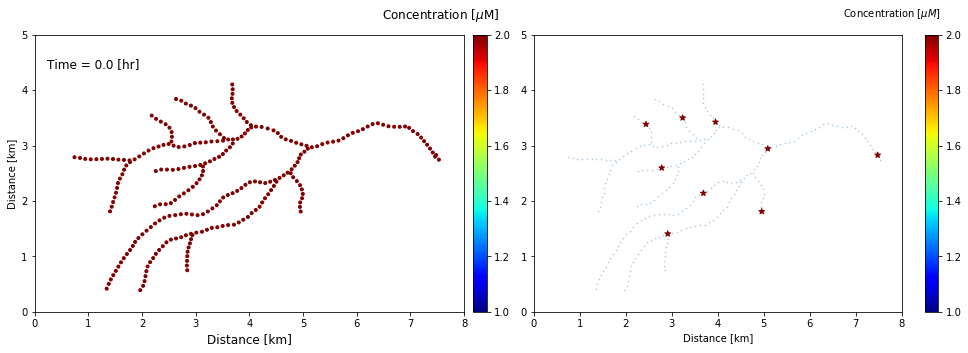

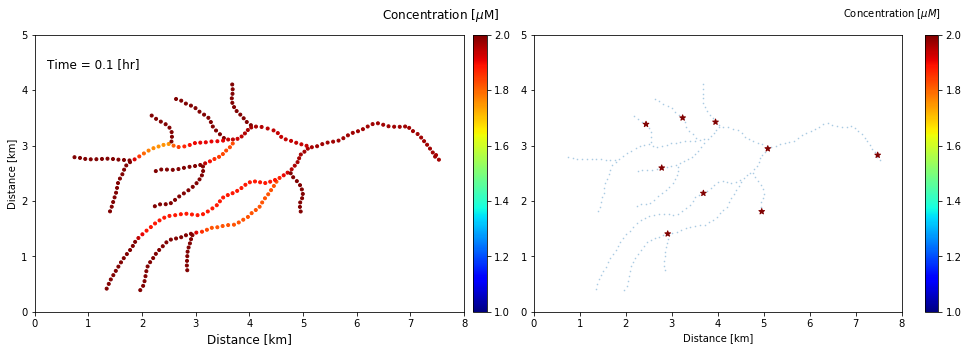

In [20]:
plot_2D_surface_2D_subgrid()

### plot_3D_surface_3D_subgrid() plots 3D stream and subgrid

In [21]:
#%matplotlib qt

def plot_3D_surface_3D_subgrid():
    x_orig = X_mesh
    y_orig = Y_mesh

    count = 0
    
    time = [np.round(t*360/3600,2) for t in range(cycles)]
    var = Suffix[1]
    for k in range(0,cycles,1):
        fig = plt.figure(figsize=(6,4))

        ax = fig.add_subplot(111,projection='3d')

        ran = Stream_C[var][k]
        ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran] #conversion from m^3 to liter

        if np.max(ran) <3:
            l_max = 2 
        else:
            l_max = 200 
        sc = ax.scatter(X_mesh,Y_mesh,1,marker=".",c=ran,cmap=plt.get_cmap('jet'),vmin=1,vmax=l_max,)#norm=matplotlib.colors.LogNorm())
        ax.text(X_mesh[-1]-0.05,Y_mesh[-1]+0.01, 1, 'Time = %s [hr]'%time[k])
        cb = plt.colorbar(sc,pad=-0.04,fraction=0.046)
        cb.ax.set_ylabel('Concentration [kg/m$^3$]',labelpad=-90, y=1.1,rotation=0,fontsize=12)


        ax.set_xlim(X0)
        ax.set_ylim(Y0)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xticklabels(Xlabels)
        ax.set_yticklabels(Ylabels)
        ax.set_xlabel('Distance [km]',fontsize=12,fontweight='normal')
        ax.set_ylabel('Distance [km]',fontsize=12,fontweight='normal')
        plt.xticks(fontsize=12,fontweight='normal')#, rotation=90)
        plt.yticks(fontsize=12,fontweight='normal')#, rotation=90)

        plt.tight_layout(h_pad=1)

        sub_c = []
        sub_x = []
        sub_y = []
        sub_top = []

        ax.view_init(45, -45) 
        ran_0 = [0 for r in ran]
        
        for x1 in vis_columns:
            #print ('X1',x1)
            sg_infile = os.path.join(path,'visdump_subgrid_%s_data.h5'%x1)
        
            ran = subgrid_C(sg_infile,sg_var='subgrid_%s-total_component_concentration'%x1,suff=Suffix[0])[k][::-1]
            ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran]
            Z_sgmesh = np.arange(0.05,1.05,0.05)#,dtype='int')
            Z_sgmesh = np.linspace(1,.4,20)
    
            sc1 = ax.scatter(X_mesh[x1],Y_mesh[x1],Z_sgmesh[::-1],marker=".",c=ran,cmap=plt.get_cmap('jet'),vmin=1,vmax=l_max)#,norm=matplotlib.colors.LogNorm())
    
        ax.set_xlim(X0)
        ax.set_ylim(Y0)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
    
        

        xlabels = Xlabels[::-1]-1
        ax.set_xticklabels(xlabels)
        ax.set_yticklabels(Ylabels)
        #ax.set_xlabel('Distance [km]',fontweight='normal',fontsize=12)
        #ax.set_ylabel('Distance [km]')
        ax.set_zlim(0,1)
        ax.set_zticks([])
        ax.grid(False)
        plt.tight_layout()
        #plt.savefig(outfile + '/%s/fig-%s.png'%(var,k),dpi=100)


        #plt.close()
        count +=1

        if count >0: 
            print ('Count: ',count)
            break

Count:  1


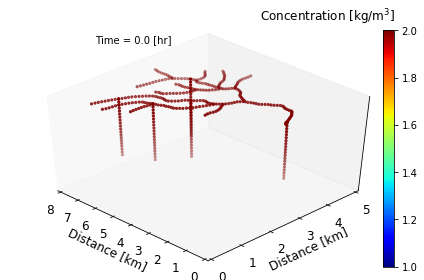

In [22]:
plot_3D_surface_3D_subgrid()

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
myMarks = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]

In [25]:
#%matplotlib qt
#this maps the subgrid concentration from a cell to the 2D surface
Hyporheic_age = [1537.88,1049.99,867.80,832.14,841.39,875.87,930.08,1003.36,1097.76,1217.63,1370.10,1566.33,1824.00,2172.24,2661.90,3389.38,4559.96,6693.86,11566.29,31446.39]
Hyporheic_age = np.cumsum([h/3600 for h in Hyporheic_age])
Marks = ['*', '+', 'x','s','^']

def plot_2D_surface_2D_subgrid_hyporheic_age():
    x_orig = X_mesh
    y_orig = Y_mesh

    count = 0
    var = Suffix[1]
    time = [np.round(t*360/3600,2) for t in range(cycles)]
    for k in range(0,cycles,1):
        fig = plt.figure(figsize=(14,5))

        ax = fig.add_subplot(121)
        plt.tight_layout()
        ran = Stream_C[var][k]
        ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran] #<-- converting to micro-moles
        
        # l_max # <-- problem/scenario dependent value 
        if np.max(ran) <3:
            l_max = 2 
        else:
            l_max = 200 
            
        print (l_max,)
        sc = ax.scatter(X_mesh,Y_mesh,marker=".",c=ran,cmap=plt.get_cmap('jet'),vmin=1,vmax=l_max)#,norm=matplotlib.colors.LogNorm())
        ax.text(X_mesh[-1]-0.02,Y_mesh[-1]+0.025, 'Time = %s [hr]'%time[k],fontsize=12,fontstyle='normal')
        cb = plt.colorbar(sc,pad=0.02,fraction=0.046)
        cb.ax.set_ylabel(r'Concentration [$\mu$M]',labelpad=-70, y=1.1,rotation=0,fontsize=12)

        ax.set_xlim(X0)
        ax.set_ylim(Y0)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xticklabels(Xlabels)
        ax.set_yticklabels(Ylabels)
        ax.set_xlabel('Distance [km]',fontsize=12, fontweight='normal')
        ax.set_ylabel('Distance [km]')
        plt.tight_layout(h_pad=1)

        #----- ***************** -----------
        # ---- Plotting subgrid model ------
        
        ax = fig.add_subplot(122)#, projection='3d')
        sub_c,sub_x,sub_y,loc_marks = [], [],[], []

        Colors = ['r','k','g']
        #for x1 in range(0,len(x_orig),100):
        for kk, x1 in enumerate(vis_columns):
            #x1 = 25
            sg_infile = os.path.join(path,'visdump_subgrid_%s_data.h5'%x1)

            ran = subgrid_C(sg_infile,sg_var='subgrid_%s-total_component_concentration'%x1,suff=var)[k]#[::-1]
            ran = [r*1e-3*microM if r>0 else 1e-12 for r in ran]
            print (ran)
            
            sc1 = ax.plot(Hyporheic_age,ran,marker='o',markersize=4)
            kk = kk + 1

            sub_c.append(kk)
            sub_x.append(x_orig[x1])
            sub_y.append(y_orig[x1])
            loc_marks.append(myMarks[kk])
        
        axins1 = inset_axes(ax, width="40%", height="40%", loc=1, borderpad=1)
        #for k1,ksub_x,sub_y, loc_marks):
        sc2 = axins1.scatter(X_mesh,Y_mesh,marker='.',cmap=plt.get_cmap('gray'),alpha=.3,s=.5)
        for k1,k2,k3 in zip(sub_x,sub_y, loc_marks):
            axins1.scatter(k1,k2,marker='o',cmap=plt.get_cmap('jet'))
       
        axins1.set_yticklabels('')
        axins1.set_xticklabels('')
       
        ax.set_xlim(0,Hyporheic_age[-1]+1)
        #ax.set_ylim(0,0.8)
        ax.set_xlabel('Hyporheic age [hr]',fontsize=12, fontweight='normal')
        ax.set_ylabel(r'Concentration [$ \mu M$]',fontsize=12, fontweight='normal')
        plt.tight_layout()
        #plt.legend()
        #plt.savefig(outfile + '/%s/fig-%s.png'%(var,k),dpi=100)

        
        #plt.close()
        count +=1

        if count >1:
            print ('Count: ',count)
            break

2
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
2


/Users/ajc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[1.9893310343795023, 1.9927545094264212, 1.9931158957004007, 1.9931456086723294, 1.993147313270358, 1.9931473778415987, 1.9931473793556882, 1.9931473793752577, 1.9931473793753622, 1.9931473793753622, 1.9931473793753622, 1.9931473793753618, 1.9931473793753622, 1.9931473793753618, 1.9931473793753618, 1.9931473793753622, 1.9931473793753627, 1.9931473793753622, 1.9931473793753618, 1.9931473793753622]
[1.9822130377438274, 1.992201907085104, 1.993082643849826, 1.9931442442045224, 1.9931472780541082, 1.9931473773375286, 1.9931473793527428, 1.9931473793752585, 1.9931473793753622, 1.9931473793753622, 1.9931473793753622, 1.9931473793753618, 1.9931473793753622, 1.9931473793753618, 1.9931473793753618, 1.9931473793753622, 1.9931473793753627, 1.9931473793753622, 1.9931473793753618, 1.9931473793753622]
[1.9938427152254454, 1.9932086021167004, 1.9931516503006104, 1.993147589943406, 1.9931473862930595, 1.9931473795165742, 1.993147379376951, 1.99314737937537, 1.9931473793753622, 1.9931473793753622, 1.99

/Users/ajc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Count:  2


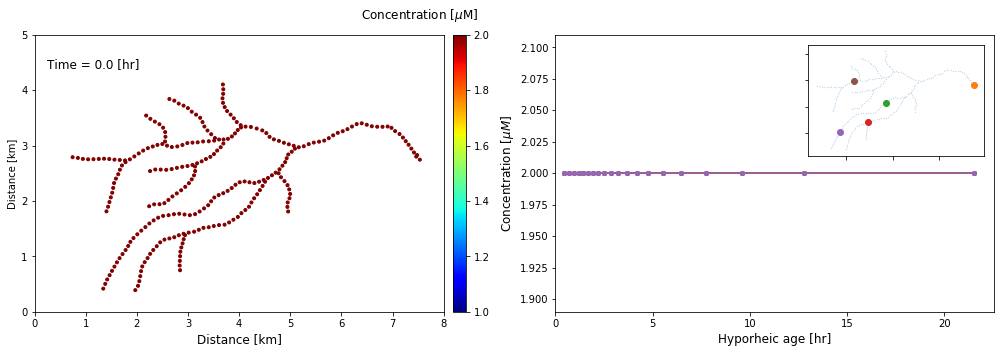

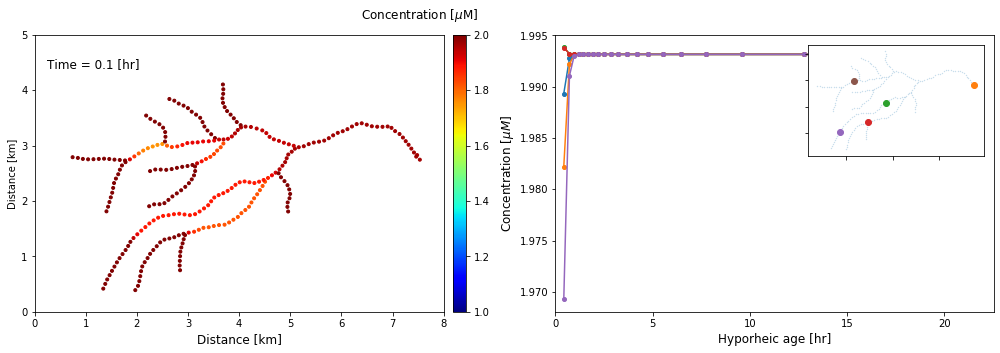

In [26]:
plot_2D_surface_2D_subgrid_hyporheic_age()